In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

from pandas.plotting import table

%load_ext autoreload
%autoreload 2

https://raw.githubusercontent.com/fivethirtyeight/data/master/election-forecasts-2020/README.md
https://raw.githubusercontent.com/fivethirtyeight/data/master/polls/README.md

In [2]:
df_census_raw = pd.read_csv(
    'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv', 
    encoding = "ISO-8859-1")
df_census_raw.head()


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


In [3]:
df_model_states_raw = pd.read_csv('https://projects.fivethirtyeight.com/2020-general-data/presidential_state_toplines_2020.csv')
df_model_states_raw.head()


,cycle,branch,model,modeldate,candidate_inc,candidate_chal,candidate_3rd,state,tipping,vpi,...,margin_lo,win_EC_if_win_state_inc,win_EC_if_win_state_chal,win_state_if_win_EC_inc,win_state_if_win_EC_chal,state_turnout,state_turnout_hi,state_turnout_lo,timestamp,simulations
0,2020,President,polls-plus,11/2/2020,Trump,Biden,NaN,Wyoming,0.000000,0.000000,...,24.38771,0.102517,0.984615,0.999756,0.001791,274643.0,320105.0,230902.0,15:47:03 2 Nov 2020,40000
1,2020,President,polls-plus,11/2/2020,Trump,Biden,NaN,Wisconsin,0.060675,2.895037,...,-14.65523,0.752727,0.937002,0.454945,0.984048,3324720.0,3750046.0,2904799.0,15:47:03 2 Nov 2020,40000
2,2020,President,polls-plus,11/2/2020,Trump,Biden,NaN,West Virginia,0.000162,0.035360,...,17.34182,0.103161,0.991018,0.999267,0.009264,750011.0,867440.0,636418.0,15:47:03 2 Nov 2020,40000
3,2020,President,polls-plus,11/2/2020,Trump,Biden,NaN,Washington,0.001962,0.076577,...,-34.04546,0.271642,0.894668,0.022222,0.993171,4117658.0,4657939.0,3585700.0,15:47:03 2 Nov 2020,40000
4,2020,President,polls-plus,11/2/2020,Trump,Biden,NaN,Virginia,0.013038,0.450685,...,-18.19572,0.778523,0.900943,0.084982,0.997313,4603649.0,5198270.0,4017221.0,15:47:03 2 Nov 2020,40000


In [4]:
df_polls_states_raw = pd.read_csv('https://projects.fivethirtyeight.com/polls-page/president_polls.csv')
df_polls_states_raw.head()


,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,created_at,notes,url,stage,race_id,answer,candidate_id,candidate_name,candidate_party,pct
0,136283,72621,2020,Iowa,383,Public Policy Polling,NaN,NaN,Public Policy Polling,263.0,...,11/2/20 09:02,NaN,https://www.publicpolicypolling.com/wp-content...,general,6223,Biden,13256,Joseph R. Biden Jr.,DEM,49.0
1,136283,72621,2020,Iowa,383,Public Policy Polling,NaN,NaN,Public Policy Polling,263.0,...,11/2/20 09:02,NaN,https://www.publicpolicypolling.com/wp-content...,general,6223,Trump,13254,Donald Trump,REP,48.0
2,136322,72647,2020,Pennsylvania,461,Susquehanna Polling & Research Inc.,NaN,NaN,Susquehanna Polling & Research Inc.,326.0,...,11/2/20 12:49,NaN,https://www.realclearpolitics.com/docs/2020/Su...,general,6249,Biden,13256,Joseph R. Biden Jr.,DEM,48.4
3,136322,72647,2020,Pennsylvania,461,Susquehanna Polling & Research Inc.,NaN,NaN,Susquehanna Polling & Research Inc.,326.0,...,11/2/20 12:49,NaN,https://www.realclearpolitics.com/docs/2020/Su...,general,6249,Trump,13254,Donald Trump,REP,49.2
4,136322,72647,2020,Pennsylvania,461,Susquehanna Polling & Research Inc.,NaN,NaN,Susquehanna Polling & Research Inc.,326.0,...,11/2/20 12:49,NaN,https://www.realclearpolitics.com/docs/2020/Su...,general,6249,Jorgensen,14611,Jo Jorgensen,LIB,1.4


In [5]:
df_model_national_raw = pd.read_csv('https://projects.fivethirtyeight.com/2020-general-data/presidential_national_toplines_2020.csv')
print(df_model_national_raw.columns)
df_model_national_raw.head()


Index(['cycle', 'branch', 'model', 'modeldate', 'candidate_inc',
       'candidate_chal', 'candidate_3rd', 'ecwin_inc', 'ecwin_chal',
       'ecwin_3rd', 'ec_nomajority', 'popwin_inc', 'popwin_chal', 'popwin_3rd',
       'ev_inc', 'ev_chal', 'ev_3rd', 'ev_inc_hi', 'ev_chal_hi', 'ev_3rd_hi',
       'ev_inc_lo', 'ev_chal_lo', 'ev_3rd_lo', 'national_voteshare_inc',
       'national_voteshare_chal', 'national_voteshare_3rd',
       'nat_voteshare_other', 'national_voteshare_inc_hi',
       'national_voteshare_chal_hi', 'national_voteshare_3rd_hi',
       'nat_voteshare_other_hi', 'national_voteshare_inc_lo',
       'national_voteshare_chal_lo', 'national_voteshare_3rd_lo',
       'nat_voteshare_other_lo', 'national_turnout', 'national_turnout_hi',
       'national_turnout_lo', 'timestamp', 'simulations'],
      dtype='object')


,cycle,branch,model,modeldate,candidate_inc,candidate_chal,candidate_3rd,ecwin_inc,ecwin_chal,ecwin_3rd,...,nat_voteshare_other_hi,national_voteshare_inc_lo,national_voteshare_chal_lo,national_voteshare_3rd_lo,nat_voteshare_other_lo,national_turnout,national_turnout_hi,national_turnout_lo,timestamp,simulations
0,2020,President,polls-plus,11/2/2020,Trump,Biden,NaN,0.102375,0.893275,NaN,...,1.848087,42.93275,50.84208,NaN,0.729393,157455824.0,167908416.0,146971712.0,15:47:03 2 Nov 2020,40000
1,2020,President,polls-plus,11/1/2020,Trump,Biden,NaN,0.102850,0.892825,NaN,...,1.823490,43.03094,50.77527,NaN,0.689592,157737856.0,168190448.0,147253728.0,23:11:03 1 Nov 2020,40000
2,2020,President,polls-plus,10/31/2020,Trump,Biden,NaN,0.105625,0.888300,NaN,...,1.835479,42.98096,50.74764,NaN,0.689802,158044784.0,168497376.0,147560672.0,22:23:03 31 Oct 2020,40000
3,2020,President,polls-plus,10/30/2020,Trump,Biden,NaN,0.099625,0.895800,NaN,...,1.847821,42.92510,50.72821,NaN,0.692837,156723120.0,167175712.0,146239008.0,21:34:03 30 Oct 2020,40000
4,2020,President,polls-plus,10/29/2020,Trump,Biden,NaN,0.108975,0.886725,NaN,...,1.866135,42.81808,50.72867,NaN,0.702630,154000000.0,164000000.0,143000000.0,22:17:03 29 Oct 2020,40000


# Data Clean Up

In [6]:
df_model_states = df_model_states_raw.copy()
df_model_states['modeldate'] = pd.to_datetime(df_model_states['modeldate'])
df_model_states['timestamp'] = pd.to_datetime(df_model_states['timestamp'])
df_model_states = df_model_states.set_index(['modeldate','state'])
print(df_model_states.columns)
df_model_states.head()


Index(['cycle', 'branch', 'model', 'candidate_inc', 'candidate_chal',
       'candidate_3rd', 'tipping', 'vpi', 'winstate_inc', 'winstate_chal',
       'winstate_3rd', 'voteshare_inc', 'voteshare_chal', 'voteshare_3rd',
       'voteshare_other', 'voteshare_inc_hi', 'voteshare_chal_hi',
       'voteshare_3rd_hi', 'voteshare_other_hi', 'voteshare_inc_lo',
       'voteshare_chal_lo', 'voteshare_3rd_lo', 'voteshare_other_lo', 'margin',
       'margin_hi', 'margin_lo', 'win_EC_if_win_state_inc',
       'win_EC_if_win_state_chal', 'win_state_if_win_EC_inc',
       'win_state_if_win_EC_chal', 'state_turnout', 'state_turnout_hi',
       'state_turnout_lo', 'timestamp', 'simulations'],
      dtype='object')


cycle     branch       model candidate_inc  \
modeldate  state                                                       
2020-11-02 Wyoming         2020  President  polls-plus         Trump   
           Wisconsin       2020  President  polls-plus         Trump   
           West Virginia   2020  President  polls-plus         Trump   
           Washington      2020  President  polls-plus         Trump   
           Virginia        2020  President  polls-plus         Trump   

                         candidate_chal  candidate_3rd   tipping       vpi  \
modeldate  state                                                             
2020-11-02 Wyoming                Biden            NaN  0.000000  0.000000   
           Wisconsin              Biden            NaN  0.060675  2.895037   
           West Virginia          Biden            NaN  0.000162  0.035360   
           Washington             Biden            NaN  0.001962  0.076577   
           Virginia               Biden            NaN  0.013038  0.450685   

                          winstate_inc  winstate_chal  ...  margin_lo  \
modeldate  state                                       ...              
2020-11-02 Wyoming            0.998375       0.001625  ...   24.38771   
           Wisconsin          0.061875       0.938125  ...  -14.65523   
           West Virginia      0.991650       0.008350  ...   17.34182   
           Washington         0.008375       0.991625  ...  -34.04546   
           Virginia           0.011175       0.988825  ...  -18.19572   

                          win_EC_if_win_state_inc  win_EC_if_win_state_chal  \
modeldate  state                                                              
2020-11-02 Wyoming                       0.102517                  0.984615   
           Wisconsin                     0.752727                  0.937002   
           West Virginia                 0.103161                  0.991018   
           Washington                    0.271642                  0.894668   
           Virginia                      0.778523                  0.900943   

                          win_state_if_win_EC_inc  win_state_if_win_EC_chal  \
modeldate  state                                                              
2020-11-02 Wyoming                       0.999756                  0.001791   
           Wisconsin                     0.454945                  0.984048   
           West Virginia                 0.999267                  0.009264   
           Washington                    0.022222                  0.993171   
           Virginia                      0.084982                  0.997313   

                          state_turnout  state_turnout_hi  state_turnout_lo  \
modeldate  state                                                              
2020-11-02 Wyoming             274643.0          320105.0          230902.0   
           Wisconsin          3324720.0         3750046.0         2904799.0   
           West Virginia       750011.0          867440.0          636418.0   
           Washington         4117658.0         4657939.0         3585700.0   
           Virginia           4603649.0         5198270.0         4017221.0   

                                   timestamp  simulations  
modeldate  state                                           
2020-11-02 Wyoming       2020-11-02 15:47:03        40000  
           Wisconsin     2020-11-02 15:47:03        40000  
           West Virginia 2020-11-02 15:47:03        40000  
           Washington    2020-11-02 15:47:03        40000  
           Virginia      2020-11-02 15:47:03        40000  

[5 rows x 35 columns]

In [7]:
df_model_national = df_model_national_raw.copy()
df_model_national['modeldate'] = pd.to_datetime(df_model_national['modeldate'])
df_model_national['timestamp'] = pd.to_datetime(df_model_national['timestamp'])
df_model_national = df_model_national.set_index(['modeldate'])
print(df_model_national.columns)
df_model_national.head()


Index(['cycle', 'branch', 'model', 'candidate_inc', 'candidate_chal',
       'candidate_3rd', 'ecwin_inc', 'ecwin_chal', 'ecwin_3rd',
       'ec_nomajority', 'popwin_inc', 'popwin_chal', 'popwin_3rd', 'ev_inc',
       'ev_chal', 'ev_3rd', 'ev_inc_hi', 'ev_chal_hi', 'ev_3rd_hi',
       'ev_inc_lo', 'ev_chal_lo', 'ev_3rd_lo', 'national_voteshare_inc',
       'national_voteshare_chal', 'national_voteshare_3rd',
       'nat_voteshare_other', 'national_voteshare_inc_hi',
       'national_voteshare_chal_hi', 'national_voteshare_3rd_hi',
       'nat_voteshare_other_hi', 'national_voteshare_inc_lo',
       'national_voteshare_chal_lo', 'national_voteshare_3rd_lo',
       'nat_voteshare_other_lo', 'national_turnout', 'national_turnout_hi',
       'national_turnout_lo', 'timestamp', 'simulations'],
      dtype='object')


,cycle,branch,model,candidate_inc,candidate_chal,candidate_3rd,ecwin_inc,ecwin_chal,ecwin_3rd,ec_nomajority,...,nat_voteshare_other_hi,national_voteshare_inc_lo,national_voteshare_chal_lo,national_voteshare_3rd_lo,nat_voteshare_other_lo,national_turnout,national_turnout_hi,national_turnout_lo,timestamp,simulations
modeldate,,,,,,,,,,,,,,,,,,,,,
2020-11-02,2020,President,polls-plus,Trump,Biden,NaN,0.102375,0.893275,NaN,0.004350,...,1.848087,42.93275,50.84208,NaN,0.729393,157455824.0,167908416.0,146971712.0,2020-11-02 15:47:03,40000
2020-11-01,2020,President,polls-plus,Trump,Biden,NaN,0.102850,0.892825,NaN,0.004325,...,1.823490,43.03094,50.77527,NaN,0.689592,157737856.0,168190448.0,147253728.0,2020-11-01 23:11:03,40000
2020-10-31,2020,President,polls-plus,Trump,Biden,NaN,0.105625,0.888300,NaN,0.006075,...,1.835479,42.98096,50.74764,NaN,0.689802,158044784.0,168497376.0,147560672.0,2020-10-31 22:23:03,40000
2020-10-30,2020,President,polls-plus,Trump,Biden,NaN,0.099625,0.895800,NaN,0.004575,...,1.847821,42.92510,50.72821,NaN,0.692837,156723120.0,167175712.0,146239008.0,2020-10-30 21:34:03,40000
2020-10-29,2020,President,polls-plus,Trump,Biden,NaN,0.108975,0.886725,NaN,0.004300,...,1.866135,42.81808,50.72867,NaN,0.702630,154000000.0,164000000.0,143000000.0,2020-10-29 22:17:03,40000


In [8]:
df_polls_states = df_polls_states_raw.copy()
df_polls_states['created_at'] = pd.to_datetime(df_polls_states['created_at'])
df_polls_states = df_polls_states.set_index(['created_at','state'])
print(df_polls_states.columns)
df_polls_states.head()


Index(['question_id', 'poll_id', 'cycle', 'pollster_id', 'pollster',
       'sponsor_ids', 'sponsors', 'display_name', 'pollster_rating_id',
       'pollster_rating_name', 'fte_grade', 'sample_size', 'population',
       'population_full', 'methodology', 'office_type', 'seat_number',
       'seat_name', 'start_date', 'end_date', 'election_date',
       'sponsor_candidate', 'internal', 'partisan', 'tracking',
       'nationwide_batch', 'ranked_choice_reallocated', 'notes', 'url',
       'stage', 'race_id', 'answer', 'candidate_id', 'candidate_name',
       'candidate_party', 'pct'],
      dtype='object')


question_id  poll_id  cycle  pollster_id  \
created_at          state                                                    
2020-11-02 09:02:00 Iowa               136283    72621   2020          383   
                    Iowa               136283    72621   2020          383   
2020-11-02 12:49:00 Pennsylvania       136322    72647   2020          461   
                    Pennsylvania       136322    72647   2020          461   
                    Pennsylvania       136322    72647   2020          461   

                                                             pollster  \
created_at          state                                               
2020-11-02 09:02:00 Iowa                        Public Policy Polling   
                    Iowa                        Public Policy Polling   
2020-11-02 12:49:00 Pennsylvania  Susquehanna Polling & Research Inc.   
                    Pennsylvania  Susquehanna Polling & Research Inc.   
                    Pennsylvania  Susquehanna Polling & Research Inc.   

                                 sponsor_ids sponsors  \
created_at          state                               
2020-11-02 09:02:00 Iowa                 NaN      NaN   
                    Iowa                 NaN      NaN   
2020-11-02 12:49:00 Pennsylvania         NaN      NaN   
                    Pennsylvania         NaN      NaN   
                    Pennsylvania         NaN      NaN   

                                                         display_name  \
created_at          state                                               
2020-11-02 09:02:00 Iowa                        Public Policy Polling   
                    Iowa                        Public Policy Polling   
2020-11-02 12:49:00 Pennsylvania  Susquehanna Polling & Research Inc.   
                    Pennsylvania  Susquehanna Polling & Research Inc.   
                    Pennsylvania  Susquehanna Polling & Research Inc.   

                                  pollster_rating_id  \
created_at          state                              
2020-11-02 09:02:00 Iowa                       263.0   
                    Iowa                       263.0   
2020-11-02 12:49:00 Pennsylvania               326.0   
                    Pennsylvania               326.0   
                    Pennsylvania               326.0   

                                                 pollster_rating_name  ...  \
created_at          state                                              ...   
2020-11-02 09:02:00 Iowa                        Public Policy Polling  ...   
                    Iowa                        Public Policy Polling  ...   
2020-11-02 12:49:00 Pennsylvania  Susquehanna Polling & Research Inc.  ...   
                    Pennsylvania  Susquehanna Polling & Research Inc.  ...   
                    Pennsylvania  Susquehanna Polling & Research Inc.  ...   

                                 ranked_choice_reallocated  notes  \
created_at          state                                           
2020-11-02 09:02:00 Iowa                             False    NaN   
                    Iowa                             False    NaN   
2020-11-02 12:49:00 Pennsylvania                     False    NaN   
                    Pennsylvania                     False    NaN   
                    Pennsylvania                     False    NaN   

                                                                                url  \
created_at          state                                                             
2020-11-02 09:02:00 Iowa          https://www.publicpolicypolling.com/wp-content...   
                    Iowa          https://www.publicpolicypolling.com/wp-content...   
2020-11-02 12:49:00 Pennsylvania  https://www.realclearpolitics.com/docs/2020/Su...   
                    Pennsylvania  https://www.realclearpolitics.com/docs/2020/Su...   
                    Pennsylvania  https://www.realclearpolitics.com/docs/2020/Su...   

                             

# Charts

Text(0, -80, 'Model Analysis by @donnellymjd')

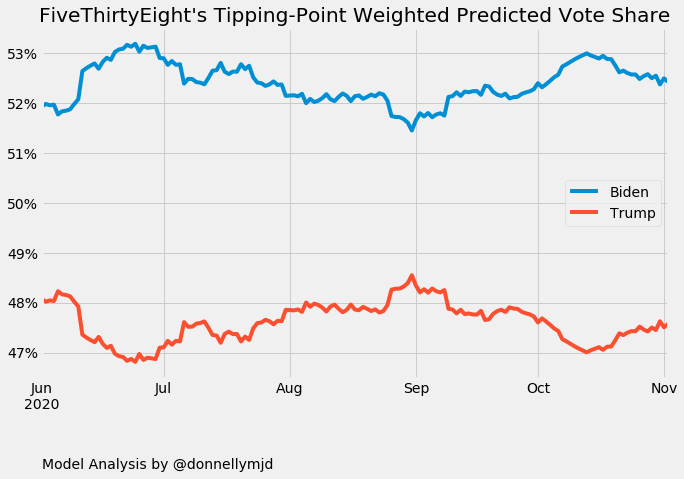

In [9]:
tippingpt_margin = df_model_states['margin'].mul(df_model_states['tipping']).unstack('modeldate').sum()

trump_weighted = tippingpt_margin.div(100).add(1).div(2)
biden_weighted = 1 - trump_weighted
ax = biden_weighted.plot(label='Biden', legend=True,
                         figsize=[10,6], 
                         title='FiveThirtyEight\'s Tipping-Point Weighted Predicted Vote Share'
                        )
trump_weighted.plot(ax=ax, label='Trump', legend=True)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
# ax.set_ylim([0,1])
ax.set_xlabel('')
plt.annotate('Model Analysis by @donnellymjd',
                 (0, 0), (0, -80), xycoords='axes fraction', textcoords='offset points', va='top')


x - y = z
x + y = 1
y = 1-x

x - (1 - x) = z
2x - 1 = z
x = (z + 1) / 2


In [10]:
ymin, ymax = .3, .7

two_party_natl = df_model_national['national_voteshare_inc'].add(
    df_model_national['national_voteshare_chal'])

tippingpt_margin_bystate = df_model_states['margin'].mul(df_model_states['tipping']).unstack('modeldate')
top5contribs = tippingpt_margin_bystate.iloc[:,-1].abs().sort_values(ascending=False).iloc[:5].index.to_list()
tippingpt_margin = tippingpt_margin_bystate.sum()

df_chart = pd.DataFrame()

df_chart['trump_weighted'] = tippingpt_margin.div(100).add(1).div(2)
df_chart['biden_weighted'] = 1 - df_chart['trump_weighted']
# ax = df_chart['biden_weighted'].plot(label='Biden (Tipping Point States)', legend=True,
#                          figsize=[10,6], 
#                          title='FiveThirtyEight\'s \n Predicted Swing State Vote Share'
#                         )
# df_chart['trump_weighted'].plot(ax=ax, label='Trump (Tipping Point States)', legend=True)

last_dt = df_chart.last_valid_index()
df_chart_summary = pd.DataFrame(
    {'Biden':[
         df_chart.loc[last_dt,'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=1),'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=7),'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=30),'biden_weighted'],
         df_model_national['national_voteshare_chal'].div(two_party_natl).loc[last_dt]
             ], 
     'Trump':[
         df_chart.loc[last_dt,'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=1),'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=7),'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=30),'trump_weighted'],
         df_model_national['national_voteshare_inc'].div(two_party_natl).loc[last_dt]
             ]},
    index=["Swing State Vote Proj. (as of {:%b %d})".format(last_dt),'Change: 1-Day', 'Change: 7-Day', 'Change: 30-Day', 'Nat\'l Popular Vote Proj.']
)

df_chart_summary['Diff.'] = df_chart_summary['Biden'] - df_chart_summary['Trump']

df_chart_summary.applymap(lambda x: '{:.1%}'.format(x))


,Biden,Trump,Diff.
Swing State Vote Proj. (as of Nov 02),52.4%,47.6%,4.8%
Change: 1-Day,-0.1%,0.1%,-0.1%
Change: 7-Day,-0.1%,0.1%,-0.1%
Change: 30-Day,0.0%,-0.0%,0.1%
Nat'l Popular Vote Proj.,54.0%,46.0%,8.0%


In [11]:
df_model_national['national_voteshare_chal'].div(two_party_natl).loc[last_dt]

0.5402282961439391

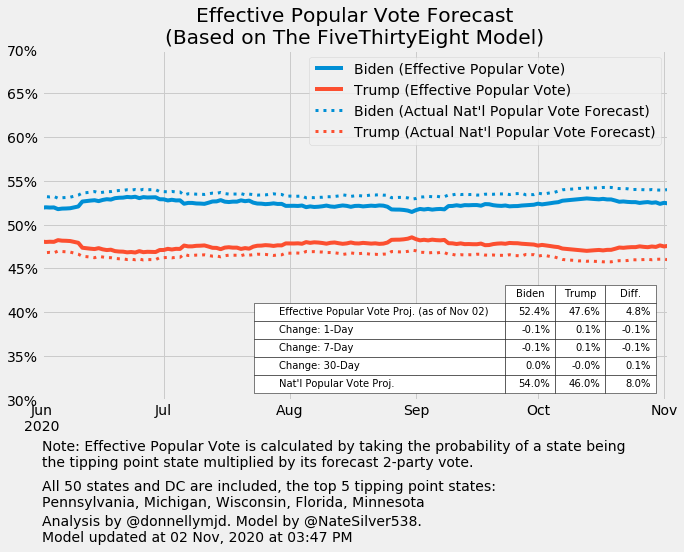

In [12]:
ymin, ymax = .3, .7

two_party_natl = df_model_national['national_voteshare_inc'].add(
    df_model_national['national_voteshare_chal'])

tippingpt_margin_bystate = df_model_states['margin'].mul(df_model_states['tipping']).unstack('modeldate')
top5contribs = tippingpt_margin_bystate.iloc[:,-1].abs().sort_values(ascending=False).iloc[:5].index.to_list()
tippingpt_margin = tippingpt_margin_bystate.sum()

df_chart = pd.DataFrame()

df_chart['trump_weighted'] = tippingpt_margin.div(100).add(1).div(2)
df_chart['biden_weighted'] = 1 - df_chart['trump_weighted']
ax = df_chart['biden_weighted'].plot(label='Biden (Effective Popular Vote)', legend=True,
                         figsize=[10,6], 
                         title='Effective Popular Vote Forecast\n(Based on The FiveThirtyEight Model)'
                        )
df_chart['trump_weighted'].plot(ax=ax, label='Trump (Effective Popular Vote)', legend=True)

last_dt = df_chart.last_valid_index()
df_chart_summary = pd.DataFrame(
    {'Biden':[
         df_chart.loc[last_dt,'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=1),'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=7),'biden_weighted'],
         df_chart.loc[last_dt,'biden_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=30),'biden_weighted'],
         df_model_national['national_voteshare_chal'].div(two_party_natl).loc[last_dt]
             ], 
     'Trump':[
         df_chart.loc[last_dt,'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=1),'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=7),'trump_weighted'],
         df_chart.loc[last_dt,'trump_weighted']
                         - df_chart.loc[last_dt-pd.Timedelta(days=30),'trump_weighted'],
         df_model_national['national_voteshare_inc'].div(two_party_natl).loc[last_dt]
             ]},
    index=["Effective Popular Vote Proj. (as of {:%b %d})".format(last_dt),'Change: 1-Day', 'Change: 7-Day', 'Change: 30-Day', 'Nat\'l Popular Vote Proj.']
)

df_chart_summary['Diff.'] = df_chart_summary['Biden'] - df_chart_summary['Trump']

df_chart_summary = df_chart_summary.applymap(lambda x: '{:.1%}'.format(x))


df_model_national['national_voteshare_chal'].div(two_party_natl).plot(
    ax=ax, linestyle=':', color='#008fd5', linewidth=3,
    label='Biden (Actual Nat\'l Popular Vote Forecast)', legend=True)
df_model_national['national_voteshare_inc'].div(two_party_natl).plot(
    ax=ax, linestyle=':', color='#fc4f30', linewidth=3,
    label='Trump (Actual Nat\'l Popular Vote Forecast)', legend=True)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
ax.set_ylim([ymin, ymax])
ax.set_xlabel('')
plt.annotate('Note: Effective Popular Vote is calculated by taking the probability of a state being\nthe tipping point state multiplied by its forecast 2-party vote.',
                 (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate('All 50 states and DC are included, the top 5 tipping point states:\n{}'.format(', '.join(top5contribs)),
                 (0, 0), (0, -80), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -115), xycoords='axes fraction', textcoords='offset points', va='top')

sum_tab = table(ax, df_chart_summary, loc='lower right', colWidths=[0.08]*3)
sum_tab.set_fontsize(10)
sum_tab.scale(1, 1.5)
sum_tab.set_zorder(100)

plt.savefig('./output/fivethirtyeight/538_prob_swing_line_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


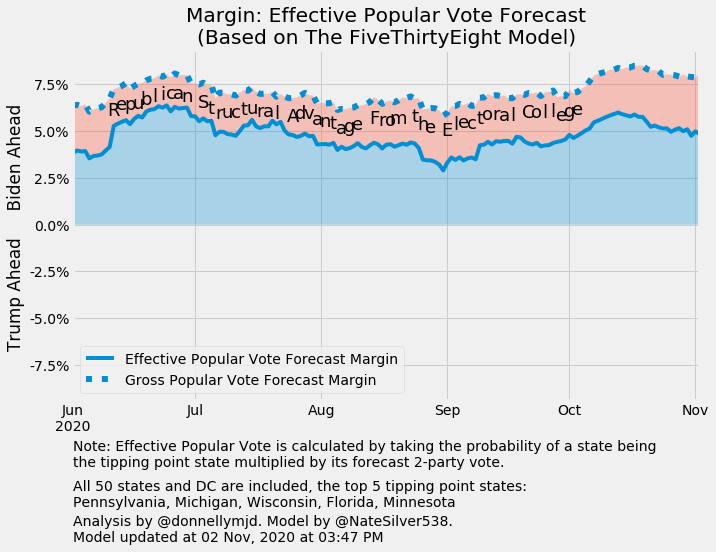

In [13]:
df_chart = pd.DataFrame()

df_chart['trump_weighted'] = tippingpt_margin.div(100).add(1).div(2)
df_chart['biden_weighted'] = 1 - df_chart['trump_weighted']

df_chart = df_chart.diff(axis=1)['biden_weighted']
# display(df_chart)

natl_margin = df_model_national['national_voteshare_chal'].div(two_party_natl).sub(.5).mul(2).sort_index()

ax = df_chart.plot(figsize=[10,6], ylim=[natl_margin.max()*-1.1, natl_margin.max()*1.1],
                   title='Margin: Effective Popular Vote Forecast\n(Based on The FiveThirtyEight Model)',
                  label='Effective Popular Vote Forecast Margin', legend=True)

natl_margin.plot(ax=ax, linestyle=':', color='#008fd5', linewidth=6,
    label='Gross Popular Vote Forecast Margin', legend=True)

plt.fill_between(df_chart.index, df_chart, 0.0, alpha=0.30)
plt.fill_between(df_chart.index, natl_margin, df_chart , alpha=0.30)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
ax.set_xlabel('')
ax.set_ylabel('Trump Ahead     Biden Ahead ')
plt.annotate('Note: Effective Popular Vote is calculated by taking the probability of a state being\nthe tipping point state multiplied by its forecast 2-party vote.',
                 (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate('All 50 states and DC are included, the top 5 tipping point states:\n{}'.format(', '.join(top5contribs)),
                 (0, 0), (0, -80), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -115), xycoords='axes fraction', textcoords='offset points', va='top')


import itertools
(xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()

# calculate a shape factor, more explanation on usage further
# it is a representation of the distortion of the actual image compared to a 
# cartesian space:
fshape = abs(10*(xmax - xmin)/(ymax - ymin)/6)

# the text you want to plot along your line
thetext = '     Republican Structural Advantage From the Electoral College'

# generate a cycler, so that the string is cycled through
lettercycler = itertools.cycle(tuple(thetext))

# generate dummy river coordinates
xvals = natl_margin.index
yvals = natl_margin

# every XX datapoints, a character is printed
markerevery = 10
angles = np.rad2deg(np.arctan((yvals[1:]-yvals[:-1])/np.ones(yvals.shape[0])*fshape))

# plot the 'river'
# ax.plot(xvals, yvals, 'b', linewidth=3)

# loop over the data points, but only plot a character every XX steps
for letter_idx in np.arange(0, len(thetext)):
    counter = np.arange(0, len(xvals), 2)[letter_idx]
    # plot the character in between two datapoints
    xcoord = (xvals[counter])
    ycoord = yvals.rolling(3, center=True, win_type='gaussian').mean(std=5)[counter] #(yvals[counter-1] + yvals[counter] + yvals[counter+1])/3

    # plot using the text method, set the rotation so it follows the line,
    # aling in the center for a nicer look, optionally, a box can be drawn
    # around the letter
    ax.text(xcoord, ycoord-0.01, thetext[letter_idx],
            fontsize=18, rotation=angles[counter],
            horizontalalignment='center', verticalalignment='center',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0))

plt.savefig('./output/fivethirtyeight/538_effective_margin_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


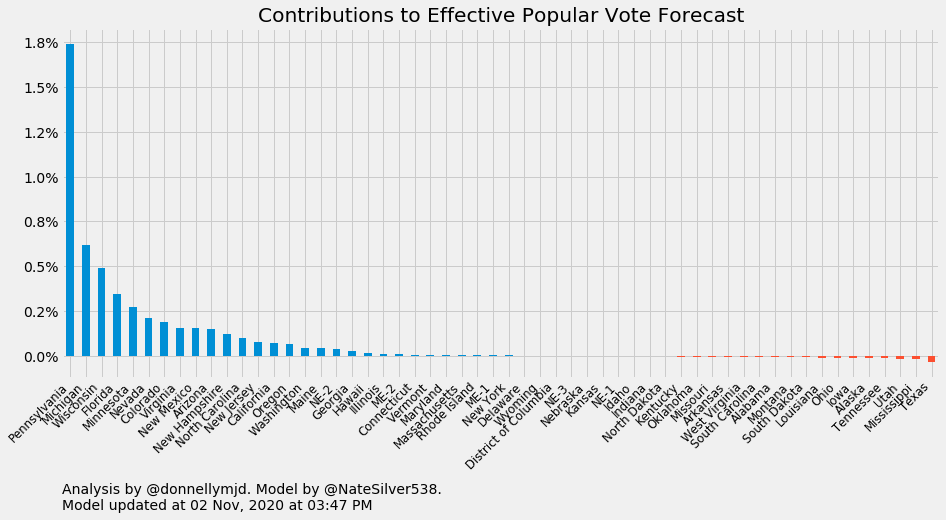

In [14]:
df_chart = tippingpt_margin_bystate.iloc[:,-1].mul(-1/100)
df_chart = df_chart.sort_values(ascending=False)

df_chart_colors = df_chart.copy()
df_chart_colors[df_chart_colors>=0] = '#008fd5'
df_chart_colors[df_chart_colors!= '#008fd5'] = '#fc4f30'

ax = df_chart.plot(kind='bar', legend=False,
                   figsize = [14,6], rot=45, color=df_chart_colors,
                   title='Contributions to Effective Popular Vote Forecast'
                  )

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))

ax.set_xlabel('')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='small',
)
xax_spacing = -20
plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -105), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig('./output/fivethirtyeight/538_prob_swing_contribs_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


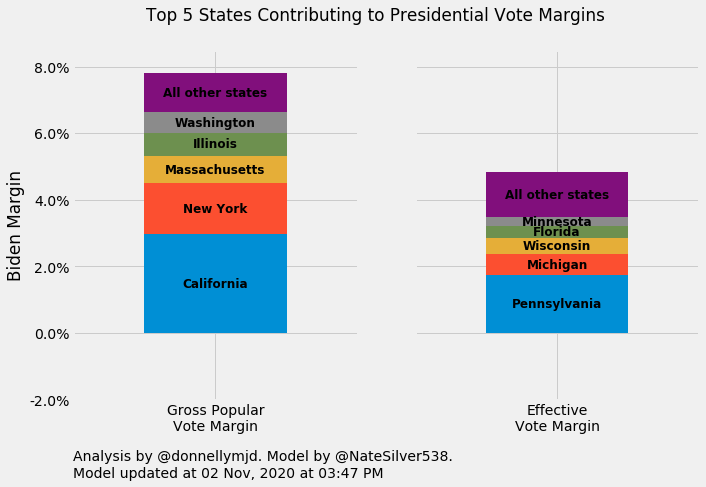

In [15]:
tippingpt_margin_bystate = df_model_states['margin'].mul(df_model_states['tipping']).unstack('modeldate')
top5contribs = tippingpt_margin_bystate.iloc[:,-1].abs().sort_values(ascending=False).iloc[:5].index.to_list()
tippingpt_margin = tippingpt_margin_bystate.sum()

df_chart = pd.DataFrame(tippingpt_margin_bystate.iloc[:,-1].mul(-1/100).sort_values(ascending=False))
df_chart.columns = ['effective_margin_contrib']
df_chart['actual_margin_contrib'] = df_model_states['margin'].mul(df_model_states['state_turnout']).div(
    df_model_states['state_turnout'].unstack('modeldate').sum()).unstack('modeldate').iloc[:,-1].mul(-1/100)

df_chart['state2'] = df_chart.index

top5_effective = df_chart.effective_margin_contrib.abs().sort_values(ascending=False).index[:5].to_list()
top5_actual = df_chart.actual_margin_contrib.abs().sort_values(ascending=False).index[:5].to_list()
othertxt = 'All other states'

df_chart_actual = df_chart.copy()
df_chart_actual['state2'] = df_chart_actual['state2'].apply(lambda x: othertxt if x not in top5_actual else x)
df_chart_actual = df_chart_actual.groupby('state2').sum().loc[top5_actual+[othertxt]]
df_chart_actual = df_chart_actual.rename(columns={'actual_margin_contrib':'Gross Popular Vote Margin'}).T

df_chart_effective = df_chart.copy()
df_chart_effective['state2'] = df_chart_effective['state2'].apply(lambda x: othertxt if x not in top5_effective else x)
df_chart_effective = df_chart_effective.groupby('state2').sum().loc[top5_effective+[othertxt]]
df_chart_effective = df_chart_effective.rename(columns={'effective_margin_contrib':'Effective Vote Margin'}).T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,6])
fig.suptitle('Top 5 States Contributing to Presidential Vote Margins')

df_chart_actual.loc[['Gross Popular Vote Margin']].plot(kind='bar', stacked=True, ax = ax1, 
                                                   ylim=[-.02, natl_margin.max()],
                                                   legend=False)
ax1.set_xticklabels(['Gross Popular\nVote Margin'], rotation=0)
for rect_idx in range(0, len(ax1.patches)):
    rect = ax1.patches[rect_idx]
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = df_chart_actual.columns[rect_idx] #f'{width:.2f}%'  # f'{width:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax1.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12, fontweight='bold')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
ax1.set_xlabel('')
ax1.set_ylabel('Biden Margin')

df_chart_effective.loc[['Effective Vote Margin']].plot(kind='bar', stacked=True, ax = ax2, sharey=True,
                                                         ylim=ax1.get_ylim(), legend=False)
ax2.set_xticklabels(['Effective\nVote Margin'], rotation=0)
for rect_idx in range(0, len(ax1.patches)):
    rect = ax2.patches[rect_idx]
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = df_chart_effective.columns[rect_idx] #f'{width:.2f}%'  # f'{width:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax2.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12, fontweight='bold')
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))
ax2.set_xlabel('')
ax2.set_ylabel('')


ax1.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig('./output/fivethirtyeight/538_prob_swing_contribs_bar_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


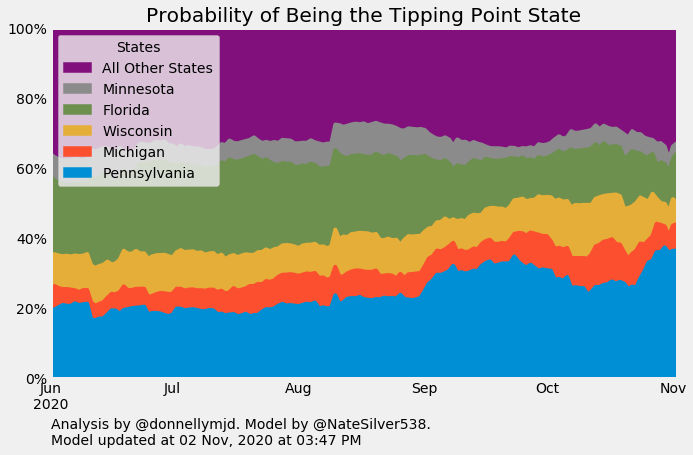

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.dates as mdates

df_chart = pd.DataFrame()
for state in top5_effective:
    df_chart[state] = df_model_states['tipping'].unstack('modeldate').loc[state]
df_chart['All Other States'] = 1-df_chart.sum(axis=1)
ax = df_chart.plot(kind='area', 
                   title='Probability of Being the Tipping Point State',
                   figsize=[10,6])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='States', loc='upper left')

# inset_days = 30
# axins = inset_axes(ax, width="10%", height="60%", loc=9, borderpad=1,
#                   axes_kwargs={'alpha': .6, 'frame_on': True})

# df_chart.plot(ax=axins, kind='area', legend=False)

# axins.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))

# axins.set_ylim(0, .7)
# axins.set_xlim(axins.get_xlim()[1]-inset_days, axins.get_xlim()[1])
# axins.set_xlabel('')

# months = mdates.MonthLocator()  # every month
# months_fmt = mdates.DateFormatter('%b')
# axins.xaxis.set_major_locator(months)
# axins.xaxis.set_major_formatter(months_fmt)
# plt.tick_params( labelbottom=False)
# axins.xaxis.set_ticklabels([])
# mark_inset(ax, axins, loc1=2, loc2=4)

# last_dt = df_chart.last_valid_index()
# df_chart_summary = pd.DataFrame(
#     {'Biden':[
#          df_chart.loc[last_dt,'biden_weighted'],
#          df_chart.loc[last_dt,'biden_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=1),'biden_weighted'],
#          df_chart.loc[last_dt,'biden_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=7),'biden_weighted'],
#          df_chart.loc[last_dt,'biden_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=30),'biden_weighted'],
#          df_model_national['national_voteshare_chal'].div(two_party_natl).loc[last_dt]
#              ], 
#      'Trump':[
#          df_chart.loc[last_dt,'trump_weighted'],
#          df_chart.loc[last_dt,'trump_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=1),'trump_weighted'],
#          df_chart.loc[last_dt,'trump_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=7),'trump_weighted'],
#          df_chart.loc[last_dt,'trump_weighted']
#                          - df_chart.loc[last_dt-pd.Timedelta(days=30),'trump_weighted'],
#          df_model_national['national_voteshare_inc'].div(two_party_natl).loc[last_dt]
#              ]},
#     index=["Effective Popular Vote Proj. (as of {:%b %d})".format(last_dt),'Change: 1-Day', 'Change: 7-Day', 'Change: 30-Day', 'Nat\'l Popular Vote Proj.']
# )

# df_chart_summary['Diff.'] = df_chart_summary['Biden'] - df_chart_summary['Trump']

# df_chart_summary = df_chart_summary.applymap(lambda x: '{:.1%}'.format(x))

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
ax.set_ylim([0, 1])
ax.set_xlabel('')
plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig('./output/fivethirtyeight/538_tipping_pt_evol_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


Text(0, -105, 'Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at 02 Nov, 2020 at 03:47 PM')

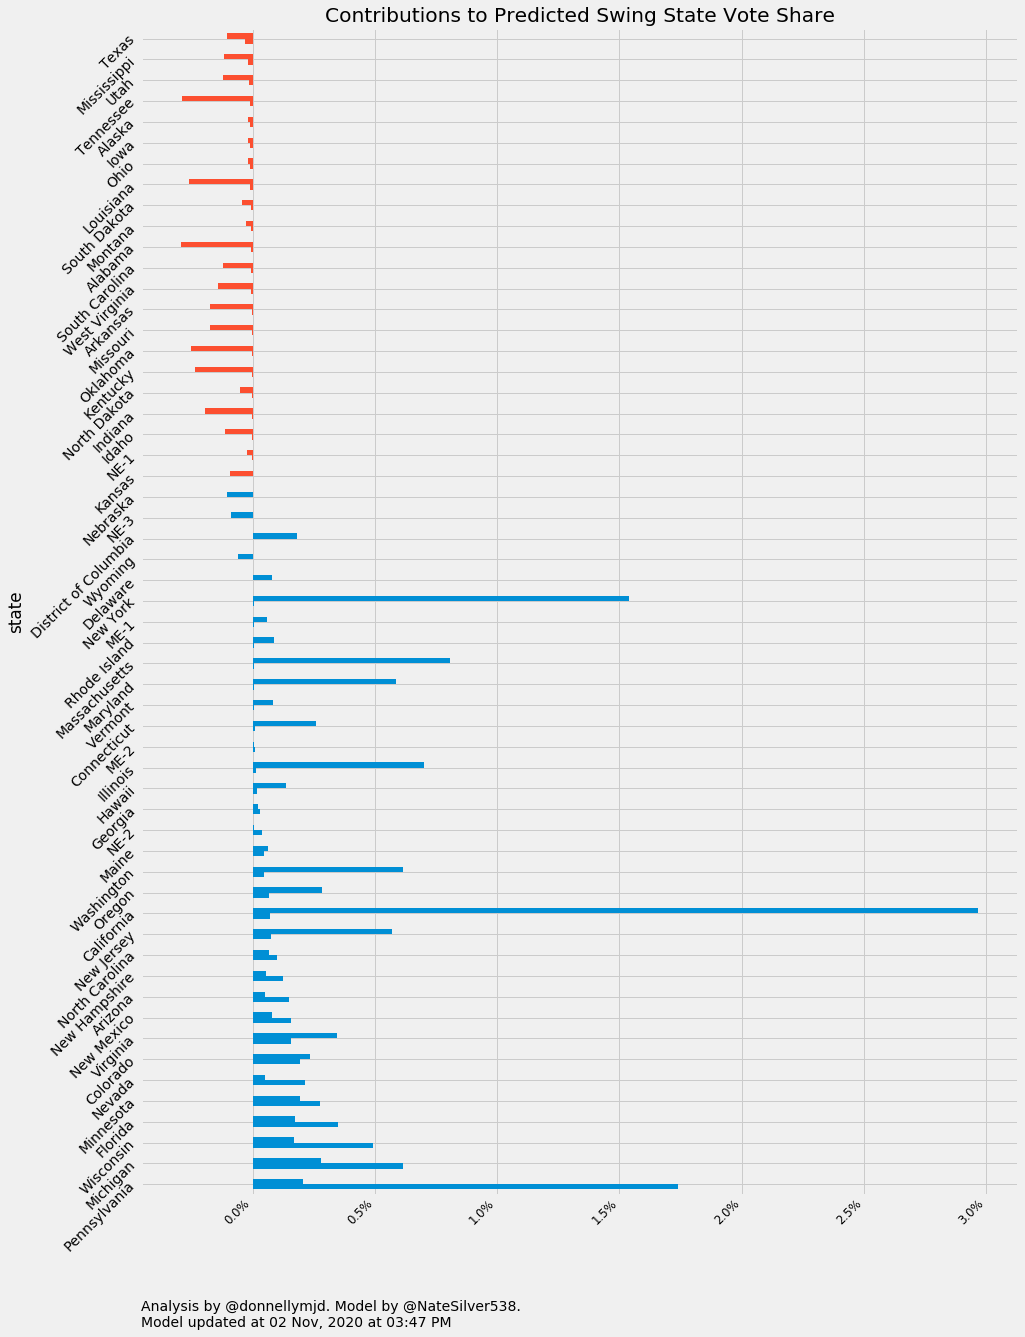

In [17]:
tippingpt_margin_bystate = df_model_states['margin'].mul(df_model_states['tipping']).unstack('modeldate')
top5contribs = tippingpt_margin_bystate.iloc[:,-1].abs().sort_values(ascending=False).iloc[:5].index.to_list()
tippingpt_margin = tippingpt_margin_bystate.sum()

df_chart = pd.DataFrame(tippingpt_margin_bystate.iloc[:,-1].mul(-1/100).sort_values(ascending=False))
df_chart.columns = ['effective_margin_contrib']
df_chart['actual_margin_contrib'] = df_model_states['margin'].mul(df_model_states['state_turnout']).div(
    df_model_states['state_turnout'].unstack('modeldate').sum()).unstack('modeldate').iloc[:,-1].mul(-1/100)
df_chart

df_chart_colors = df_chart.copy()
df_chart_colors[df_chart_colors>=0] = '#008fd5'
df_chart_colors[df_chart_colors!= '#008fd5'] = '#fc4f30'
chart_colors = df_chart_colors['effective_margin_contrib'].to_list()

ax = df_chart.plot(kind='barh', legend=False,
                   figsize = [14,20], rot=45, color=[chart_colors]*2,
                   title='Contributions to Predicted Swing State Vote Share'
                  )

ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.1%}'))

ax.set_xlabel('')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='small',
)
xax_spacing = -20
plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -105), xycoords='axes fraction', textcoords='offset points', va='top')

# plt.savefig('./output/fivethirtyeight/538_prob_swing_contribs_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
#             bbox_inches='tight')


Will try to do a similar analysis using your model when I get time. In the meantime, this approach to understanding the state of the election also gives us a better idea of how much each state's marginal voter is worth relative to the highest value state: PA.

Note the log scale.

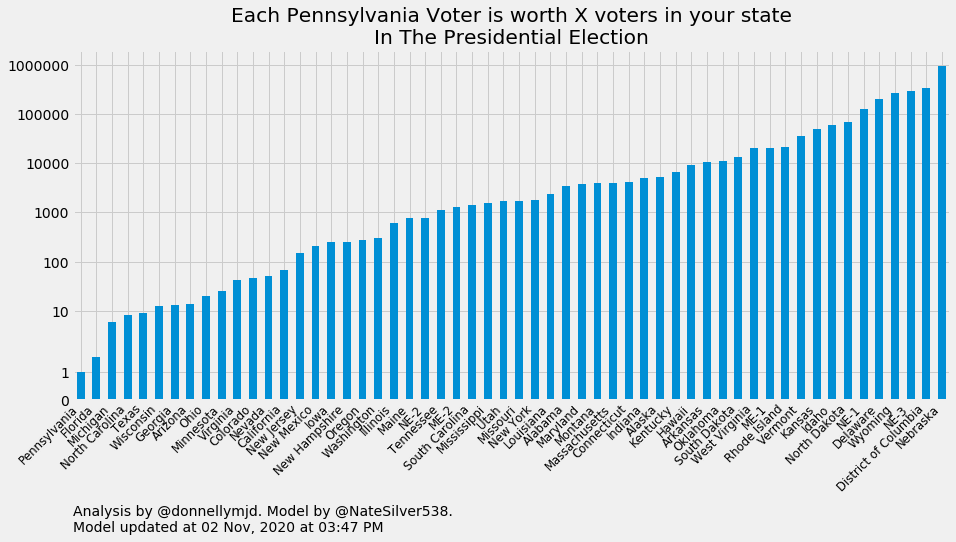

In [18]:
turnout = df_model_states['state_turnout'].unstack('modeldate').iloc[:,-1]
weighted_turnout = df_model_states['tipping'].unstack('modeldate').iloc[:,-1] * turnout
weighted_turnout = weighted_turnout.replace(0, np.nan)
voter_value = weighted_turnout.loc['Pennsylvania']/ weighted_turnout
voter_value = voter_value.fillna(turnout)

ax = voter_value.sort_values().plot(kind='bar', legend=False,
                   figsize = [14,6], rot=45,
                   title='Each Pennsylvania Voter is worth X voters in your state\nIn The Presidential Election'
                  )
ax.set_yscale('symlog')
# ax.yaxis.set_major_formatter(
#     mpl.ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    
ax.set_xlabel('')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    va='top',
    fontweight='light',
    fontsize='small'
)

plt.annotate('Analysis by @donnellymjd. Model by @NateSilver538.\nModel updated at {}'.format(
        df_model_states.timestamp.max().strftime("%d %b, %Y at %I:%M %p")),
                 (0, 0), (0, -105), xycoords='axes fraction', textcoords='offset points', va='top')

plt.savefig('./output/fivethirtyeight/538_PA_voter_value_{}.png'.format(pd.Timestamp.today().strftime("%Y%m%d")),
            bbox_inches='tight')


In [19]:
df_polls_states.query('state =="Pennsylvania"')

question_id  poll_id  cycle  pollster_id  \
created_at          state                                                    
2020-11-02 12:49:00 Pennsylvania       136322    72647   2020          461   
                    Pennsylvania       136322    72647   2020          461   
                    Pennsylvania       136322    72647   2020          461   
2020-11-02 09:28:00 Pennsylvania       136293    72629   2020         1478   
                    Pennsylvania       136293    72629   2020         1478   
...                                       ...      ...    ...          ...   
2019-03-26 10:57:00 Pennsylvania        93786    57754   2020         1483   
2019-03-26 10:58:00 Pennsylvania        93787    57754   2020         1483   
                    Pennsylvania        93787    57754   2020         1483   
                    Pennsylvania        93788    57754   2020         1483   
                    Pennsylvania        93788    57754   2020         1483   

                                                             pollster  \
created_at          state                                               
2020-11-02 12:49:00 Pennsylvania  Susquehanna Polling & Research Inc.   
                    Pennsylvania  Susquehanna Polling & Research Inc.   
                    Pennsylvania  Susquehanna Polling & Research Inc.   
2020-11-02 09:28:00 Pennsylvania                         Research Co.   
                    Pennsylvania                         Research Co.   
...                                                               ...   
2019-03-26 10:57:00 Pennsylvania                              Optimus   
2019-03-26 10:58:00 Pennsylvania                              Optimus   
                    Pennsylvania                              Optimus   
                    Pennsylvania                              Optimus   
                    Pennsylvania                              Optimus   

                                 sponsor_ids sponsors  \
created_at          state                               
2020-11-02 12:49:00 Pennsylvania         NaN      NaN   
                    Pennsylvania         NaN      NaN   
                    Pennsylvania         NaN      NaN   
2020-11-02 09:28:00 Pennsylvania         NaN      NaN   
                    Pennsylvania         NaN      NaN   
...                                      ...      ...   
2019-03-26 10:57:00 Pennsylvania         NaN      NaN   
2019-03-26 10:58:00 Pennsylvania         NaN      NaN   
                    Pennsylvania         NaN      NaN   
                    Pennsylvania         NaN      NaN   
                    Pennsylvania         NaN      NaN   

                                                         display_name  \
created_at          state                                               
2020-11-02 12:49:00 Pennsylvania  Susquehanna Polling & Research Inc.   
                    Pennsylvania  Susquehanna Polling & Research Inc.   
                    Pennsylvania  Susquehanna Polling & Research Inc.   
2020-11-02 09:28:00 Pennsylvania                         Research Co.   
                    Pennsylvania                         Research Co.   
...                                                               ...   
2019-03-26 10:57:00 Pennsylvania         Firehouse Strategies/Øptimus   
2019-03-26 10:58:00 Pennsylvania         Firehouse Strategies/Øptimus   
                    Pennsylvania         Firehouse Strategies/Øptimus   
                    Pennsylvania         Firehouse Strategies/Øptimus   
                    Pennsylvania         Firehouse Strategies/Øptimus   

                                  pollster_rating_id  \
created_at          state                              
2020-11-02 12:49:00 Pennsylvania               326.0   
                    Pennsylvania               326.0   
                    Pennsylvania               326.0   
2020-11-02 09:28:00 Pennsylvania               449.0   
                    Pennsylvania         